In [1]:
import os.path
import sys
import logging

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
import sklearn.svm
import sklearn.linear_model
import sklearn.ensemble

sys.path.append("../../")  # trick to import clairvoya from internal notebook directory
import clairvoya.runbench
import clairvoya.pulearning
import clairvoya.voya_plotter
import clairvoya.datasetup
import cPickle as pickle

%matplotlib inline

voya_logger = logging.getLogger('voya_notebook')
voya_logger.setLevel(logging.INFO)
fh = logging.FileHandler('voya_notebook.log')
fh.setLevel(logging.DEBUG)
voya_logger.addHandler(fh)
logging.getLogger('clairvoya').addHandler(fh)

# Run Conditions

In [2]:
num_runs_per = 15

pos_to_unlab_range = (0.1, 0.5, 1, 3, 10, 50)

In [3]:
df = pd.read_csv('../data/test1_uni_f.csv')
df.head()

,cid,label,cid/tech/ecommerce,url/tech/traffic_rank,url/tech/conversion_tracking,url/tech/html_ids,url/tech/html_classes,url/tech/login,url/tech/platform_count,url/tech/subscribe,url/tech/univ_analytics,url/tech/tech_sum,url/tech/likes,url/tech/feedback,url/tech/analytics_count,url/tech/video_count,url/tech/mobile_aware
0,899001,1,1,4.550876,0,1.672098,2.296665,1,6,1,0,1,5.264343,0,1,0,0
1,1703999,1,0,7.154740,0,0.477121,1.204120,0,0,0,0,1,0.000000,0,0,0,0
2,2247971,1,0,6.422567,0,2.053078,1.477121,1,0,0,0,0,0.000000,0,1,0,0
3,308163,1,0,6.796991,0,0.000000,0.000000,0,0,0,0,0,0.000000,0,0,0,0
4,1935839,1,0,6.796991,0,1.000000,1.000000,0,0,0,0,0,0.000000,0,0,0,0


In [4]:
df.describe()

,cid,label,cid/tech/ecommerce,url/tech/traffic_rank,url/tech/conversion_tracking,url/tech/html_ids,url/tech/html_classes,url/tech/login,url/tech/platform_count,url/tech/subscribe,url/tech/univ_analytics,url/tech/tech_sum,url/tech/likes,url/tech/feedback,url/tech/analytics_count,url/tech/video_count,url/tech/mobile_aware
count,909495.000000,909495.000000,909495.000000,909495.000000,909495.000000,909495.000000,909495.000000,909495.000000,909495.000000,909495.000000,909495.000000,909495.000000,909495.000000,909495.000000,909495.000000,909495.000000,909495.000000
mean,1696254.783314,-0.003236,0.046376,6.753796,0.016050,0.704951,0.796215,0.167617,0.578420,0.051359,0.078383,0.416460,0.385278,0.001360,0.036306,0.036989,0.211666
std,997505.191129,0.068772,0.210299,0.331563,0.196548,0.703598,0.796143,0.373526,1.194542,0.220730,0.268774,0.492972,1.028116,0.036854,0.204897,0.195566,0.479409
min,3.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,877386.500000,0.000000,0.000000,6.796991,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1716996.000000,0.000000,0.000000,6.796991,0.000000,0.698970,0.698970,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2349450.000000,0.000000,0.000000,6.796991,0.000000,1.322219,1.544068,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4289281.000000,1.000000,1.000000,7.406857,127.000000,3.741782,3.625827,1.000000,8.000000,1.000000,1.000000,1.000000,7.973324,1.000000,4.000000,3.000000,2.000000


In [5]:
num_labels = pd.value_counts(df[['label']].values.ravel())  # numbers in each group
print num_labels
num_pos = num_labels[1]
num_neg = num_labels[-1]
num_unl = num_labels[0]

 0    905184
-1      3627
 1       684
dtype: int64


In [6]:
df_pos_neg = df[df['label'] != 0]
df_unlab = df[df['label'] == 0]

In [7]:
def generate_mixed_df(pos_to_unl_frac):
    df_unlab.reindex(np.random.permutation(df_unlab.index))
    num_required_unlab = int(num_pos * pos_to_unl_frac)
    mixed_df = df_pos_neg.append(df_unlab[:num_required_unlab], ignore_index=True)
    return mixed_df

In [8]:
mixed_df = generate_mixed_df(2)

# Configuring the benchmark

In [9]:
clfs=('Logistic Regression', 'Gradient Boosting', 'LR_PosOnly(E&N2008)', 'Random Forrest', 'SVM_DoubleWeight(E&N2008)')
auc_results = {clf_name:[] for clf_name in clfs}
for g_num, pos_to_unlab in enumerate(pos_to_unlab_range):
    voya_logger.info('Running classifiers for gamma={} ({}/{})'.format(pos_to_unlab, g_num, len(pos_to_unlab_range)))
    run_results = {clf_name:[] for clf_name in clfs}
    for i in xrange(num_runs_per):
        
        mixed_df = generate_mixed_df(pos_to_unlab)

        config = {
            "data_file": mixed_df,
            "out_path": None,
            "num_cores": 3,
            "verbosity": 0,
            "test_size": 0.2,
            "pu_learning": True,
        }

        LR_estimator = sklearn.linear_model.LogisticRegression(C=0.4, penalty='l1')
        svc_estimator = sklearn.svm.SVC(C=2.5, kernel='linear', class_weight='auto', probability=True)

        classifiers = {
    #         'Bagging LR': sklearn.ensemble.BaggingClassifier(LR_estimator, n_estimators=200, max_samples=0.3)
            'Logistic Regression': sklearn.linear_model.LogisticRegression(),
            'Gradient Boosting': sklearn.ensemble.GradientBoostingClassifier(n_estimators=100,
                                                                             learning_rate=0.1, max_depth=2),
            'LR_PosOnly(E&N2008)': clairvoya.pulearning.PosOnly(LR_estimator, hold_out_ratio=0.2),
            'SVM_DoubleWeight(E&N2008)': clairvoya.pulearning.PULearnByDoubleWeighting(svc_estimator), 
            'Random Forrest': sklearn.ensemble.RandomForestClassifier(n_jobs=config["num_cores"]),
        }

        classifiers_gridparameters = {clf_name: None for clf_name in clfs}

        results_dict = clairvoya.runbench.run_benchmark(config, classifiers, classifiers_gridparameters)
        for clf_name in clfs:
            run_results[clf_name].append(results_dict[clf_name]['auc_score'])
    for clf_name in clfs:
        auc_results[clf_name].append(run_results[clf_name])

INFO:voya_notebook:Running classifiers for gamma=0.1 (0/5)
/Users/ryan/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:498: UserWarning: MinMaxScaler assumes floating point values as input, got int64
  "got %s" % (estimator, X.dtype))
INFO:voya_notebook:Running classifiers for gamma=0.5 (1/5)
INFO:voya_notebook:Running classifiers for gamma=1 (2/5)
INFO:voya_notebook:Running classifiers for gamma=3 (3/5)
INFO:voya_notebook:Running classifiers for gamma=10 (4/5)


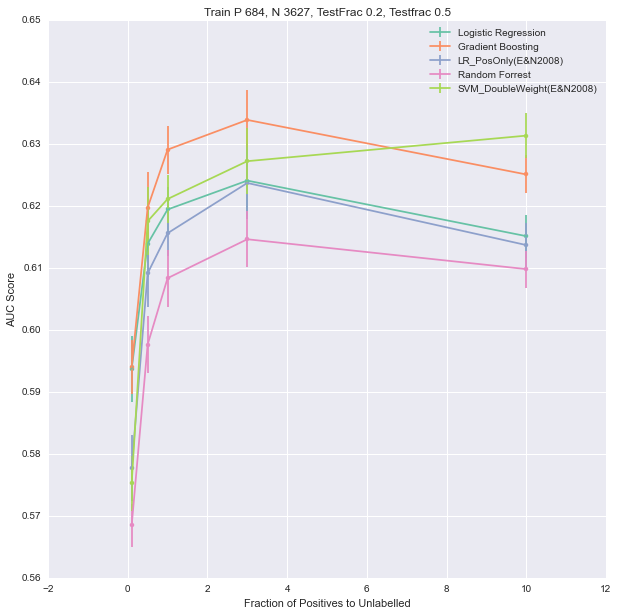

In [14]:
colors = seaborn.color_palette("Set2", 10)

plt.figure(figsize=(10,10))
for i, clf_name in enumerate(clfs):
    auc_scores = np.array(auc_results[clf_name])
    std_error = auc_scores.std(axis=1) / np.sqrt(num_runs_per)
    plt.errorbar(pos_to_unlab_range, auc_scores.mean(axis=1), yerr=std_error, label=clf_name,
                 c=colors[i], capthick=0)
    plt.scatter(pos_to_unlab_range, auc_scores.mean(axis=1), c=colors[i], lw=0)
    
    plt.ylabel('AUC Score')
    plt.xlabel('Fraction of Positives to Unlabelled')
    plt.legend()
    
    title = "Train P {}, N {}, TestFrac {}, Testfrac {}".format(
        num_pos, num_neg, 0.2, test_num_pos_frac)
    plt.title(title)
    plt.savefig('plots/{}.png'.format(title))

In [ ]:
# Easy results save for now
with open(os.path.join('result_data', 'test 1 ' + title + '.pickle'), 'wb') as f:
    pickle.dump(auc_results, f)